# SIT307 - Machine Learning Challenge (Assignment 3)

Our chosen dataset is [Life Expectancy (WHO)](https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who).

Prepared by

| Student           | Student ID |
|-------------------|------------|
| HOOMAN SHYKHIPOUR | 220060109  |
| SARAH GOSLING     | 220094149  |
| DEVIN JAYASINGHE  | 220228075  |
| RYAN WAITES       | 215127684  |
| ANTHONY GEORGE    | 220180567  |
| MATT KINNIA       | 219311697  |

In [148]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mean
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import missingno as msno

In [149]:
# Ignore inline warnings thrown by packages
warnings.filterwarnings("ignore")

In [150]:
life_df = pd.read_csv('Cleaned_Life_Expectancy_Data.csv', delimiter=',')

# Section 1: Introduction

# Section 2: Machine Learning

## Section 2.1: Regression

In [151]:
# Import the required packages for our regression models.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [152]:
# Pull the required columns from the source dataset.
reg_life_df = life_df[["STATUS", "LIFE_EXPECTANCY", "ALCOHOL", "ADULT_MORTALITY","MEASLES","POLIO","DIPHTHERIA", "BMI", "INFANT_DEATHS","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
reg_life_df = reg_life_df.dropna()

# Define our x (independent) and y (dependent) variables for our regression models.
x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]
y = reg_life_df["LIFE_EXPECTANCY"]

In [153]:
# Split our dataset into training and testing samples. We are using 80% for training and 20% for testing.
# NOTE: Using a the "random_state" parameter ensures we get repeatable results for each execution.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale our train and test features using standardization 
std_scaler = StandardScaler()
std_scaler.fit(x_train.values)

x_train_scaled = std_scaler.transform(x_train.values)
x_test_scaled  = std_scaler.transform(x_test.values)

In [154]:
# Mean Absolute Error (MAE) for testing
def mae(y_true, y_prediction):
    return np.mean(np.abs(y_prediction - y_true)) 

### Linear Regression

Using an ordinary least squares Linear Regression model we can predict `LIFE_EXPECTANCY` using a one or more explanatory features.

In [155]:
# Create and train the ordinary least squares Linear Regression model based on our training data.
linear_regression = LinearRegression()
linear_regression.fit(x_train_scaled, y_train)

LinearRegression()

In [156]:
# Run a prediction using our testing data.
y_pred = linear_regression.predict(x_test_scaled)

#### Performance

In [157]:
# Print the model's performance indicators.
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")  
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")  
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Coefficient of determination: 0.9238680302251875
Mean Absolute Error: 1.8176607104482652
Mean Squared Error: 6.530865259277718
Root Mean Squared Error: 2.555555763288627


In [158]:
# Print actual vs predicted values. 
pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head()

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

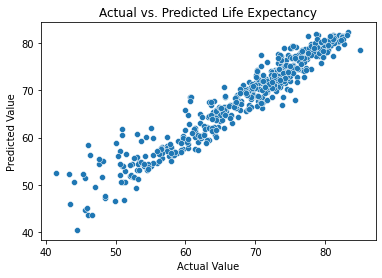

In [159]:
# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=y_pred)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

#### Performance

Predict life expectancy using previously unseen data.

In [160]:
# Provide a set of previously unseen features.
# STATUS, ALCOHOL, ADULT_MORTALITY, BMI, INFANT_DEATHS, MEASLES, POLIO, DIPHTHERIA, THINNESS_5-9_YEARS, THINNESS_10-19_YEARS, SCHOOLING, INCOME_COMPOSITION_OF_RESOURCES
new_features = [[0, 5, 300, 19, 82, 1495, 68, 40, 18, 17, 14, 0.5]]

# Scale these features using standardization 
new_features_scaled = std_scaler.transform(new_features)

# Predict the life expectancy given the new features
new_pred = linear_regression.predict(new_features_scaled)
print(f"Given provided features, the predicted life expectancy is: {y_pred[0]}")

Given provided features, the predicted life expectancy is: 68.60883937173716


### Lasso Regression 

In [161]:
from sklearn.linear_model import Lasso,LassoCV
from sklearn.preprocessing import StandardScaler

In [162]:
##  finding best ALPHA value for L1 regularization,implementing lassoCV
# Scale the data 
std = StandardScaler()
std.fit(x_train.values)
# Scale the Predictors for the train and test set
x_train_scaled = std.transform(x_train.values)
x_test_scaled = std.transform(x_test.values)
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(x_train_scaled, y_train)
# This is the best alpha value found
lasso_model.alpha_ 


0.012173827277396614

In [163]:
# showing all coefficients with optimal alpha
list(zip(x_train.columns, lasso_model.coef_))

[('STATUS', 0.1254014418298149),
 ('ALCOHOL', -0.01712369191563245),
 ('ADULT_MORTALITY', -4.479060598744764),
 ('BMI', 0.1818122224565193),
 ('INFANT_DEATHS', 0.15874142618205453),
 ('MEASLES', -0.2850918092368943),
 ('POLIO', -0.0),
 ('DIPHTHERIA', 1.0785488519160238),
 ('THINNESS_5-9_YEARS', -0.036196874877915786),
 ('THINNESS_10-19_YEARS', -0.11107439652977473),
 ('SCHOOLING', 0.0),
 ('INCOME_COMPOSITION_OF_RESOURCES', 3.9669492280262615)]

In [164]:
# find the Mean absolute error (MAE) on test data
mae(y_test, lasso_model.predict(x_test_scaled))

1.816059783150613

In [165]:
print(f"Coefficient of determination: {r2_score(y_test, lasso_model.predict(x_test_scaled))}")
print(f"Mean squared error: {mean_squared_error(y_test,lasso_model.predict(x_test_scaled))}")

Coefficient of determination: 0.9240796076950468
Mean squared error: 6.512715407754935


In [166]:
from sklearn.linear_model import lars_path
print("Regularization path computation using the LARS ...")
alphas, _, coefs = lars_path(x_train_scaled, y_train.values, method='lasso')

Regularization path computation using the LARS ...


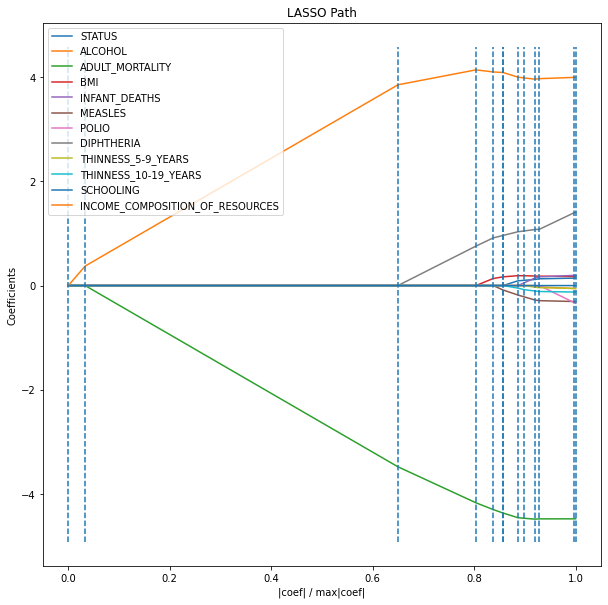

In [167]:
# plotting the LARS path
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(x_train.columns)
plt.show()

### Artificial Neural Network

In [168]:
reg_life_df.shape

(2736, 13)

In [169]:
# Pull the required columns from the source dataset.
x = reg_life_df[["STATUS", "ALCOHOL", "ADULT_MORTALITY", "BMI", "INFANT_DEATHS","MEASLES","POLIO","DIPHTHERIA","THINNESS_5-9_YEARS","THINNESS_10-19_YEARS", "SCHOOLING","INCOME_COMPOSITION_OF_RESOURCES"]]

In [170]:
print(len(x))

2736


In [171]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

# split dataset into train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# standardise the features individually before applying ML
sc=StandardScaler()

# fit standardised features
scaler = sc.fit(x_train)

print(x_train)

# transform train and test data
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#mlp = MLPRegressor(random_state=1, max_iter=10000).fit(x_train, y_train)
mlp = MLPRegressor(hidden_layer_sizes=(150),
                   max_iter = 10000, 
                   activation = 'relu',
                   solver = 'adam').fit(x_train_scaled, y_train)

# get prediction from test data 
predict_test = mlp.predict(x_test_scaled)

      STATUS  ALCOHOL  ADULT_MORTALITY   BMI  INFANT_DEATHS  MEASLES  POLIO  \
247        1    10.47               87  61.3              0       98   99.0   
2616       0     2.05              146  78.0              0        0   88.0   
2430       0     1.68              144  14.6              5      309   98.0   
347        0     4.90              652  32.2              2        1   96.0   
1154       1    10.88              139  63.6              0        1   99.0   
...      ...      ...              ...   ...            ...      ...    ...   
1702       0     2.06              172  65.8              0        0   81.0   
1159       1    11.64              165  65.0              1        0   99.0   
1194       0     1.27              211  13.5           1500    36711   65.0   
1358       0     5.75              284  44.4              8       94   95.0   
924        0     9.31               98  57.1              0        0   96.0   

      DIPHTHERIA  THINNESS_5-9_YEARS  THINNESS_10-1

In [172]:
# print coefficients and errors
print(f"Coefficient of determination: {r2_score(y_test, predict_test)}")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predict_test))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predict_test))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predict_test)))

Coefficient of determination: 0.9540023979597354
Mean Absolute Error: 1.384360624256493
Mean Squared Error: 3.9458343461150247
Root Mean Squared Error: 1.986412431021067


[Text(0.5, 1.0, 'Actual vs. Predicted Life Expectancy'),
 Text(0.5, 0, 'Actual Value'),
 Text(0, 0.5, 'Predicted Value')]

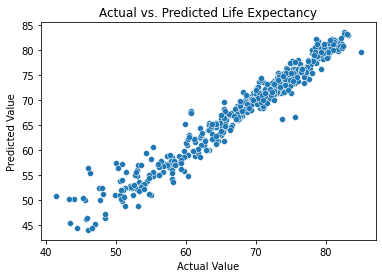

In [173]:
# Plot actual vs predicted values.
plot = sns.scatterplot(x=y_test, y=predict_test)
plot.set(title="Actual vs. Predicted Life Expectancy", xlabel="Actual Value", ylabel="Predicted Value")

In [174]:
# compare actual data with predicted
df_temp = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_temp.head(10)

,Actual,Predicted
783,70.2,68.608839
1615,69.6,68.791612
410,53.3,54.768536
1852,79.1,79.510794
523,45.7,44.771927
881,64.2,60.560052
883,63.3,59.547605
1444,73.6,74.201069
511,79.1,78.469725
1554,64.7,62.346559


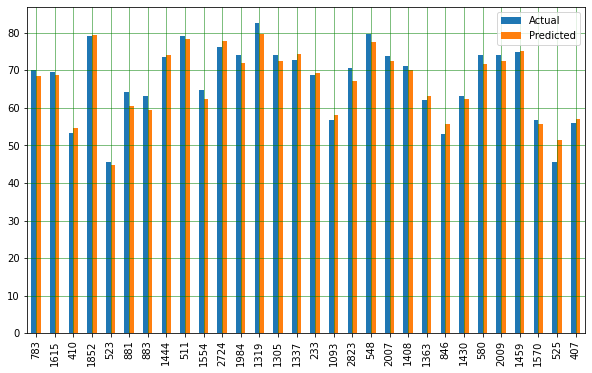

In [175]:
# visualise actual vs predicted
df_temp = df_temp.head(30)
df_temp.plot(kind='bar',figsize=(10,6))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

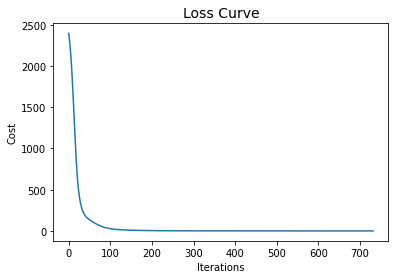

In [176]:
# plot the loss curve of the ML algorithm
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

# Predicting Life Expectancy 
### Given values for Alcohol, BMI and Adult Mortality, we can observe the ANN's ability to predict Life Expectancy

In [177]:
'''
Print an entry to use values for prediction
'''
print(reg_life_df.loc[[100]])

     STATUS  LIFE_EXPECTANCY  ALCOHOL  ADULT_MORTALITY  MEASLES  POLIO  \
100       0             73.9     4.09              128        0   96.0   

     DIPHTHERIA   BMI  INFANT_DEATHS  THINNESS_5-9_YEARS  \
100        95.0  51.9              1                 2.1   

     THINNESS_10-19_YEARS  SCHOOLING  INCOME_COMPOSITION_OF_RESOURCES  
100                   2.0       12.7                            0.729  


In [178]:
'''
initialize prediction data
'''

# here we're getting a life expectancy prediction for the given values
data = [[1, 51, 129]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = [["ALCOHOL", 'BMI', 'ADULT_MORTALITY']])
  
# print dataframe.
df

,ALCOHOL,BMI,ADULT_MORTALITY
0,1,51,129


In [179]:
x = reg_life_df[["ALCOHOL", "BMI", "ADULT_MORTALITY", "LIFE_EXPECTANCY"]]
z = df[["ALCOHOL", 'BMI', 'ADULT_MORTALITY']]

In [180]:
# fit standardised features
scaler = sc.fit(z)

# transform train and test data
z_scaled = scaler.transform(z)

x_array = x.to_numpy()

mlp2 = MLPRegressor(hidden_layer_sizes=(250),
                   max_iter = 100000, 
                    batch_size='auto',
                   activation = 'relu',
                   solver = 'adam').fit(x_array[:,:-1], x_array[:,-1])

predict_result = mlp2.predict(z_scaled)

# print prediction
print("Predicted Life Expectancy: ", predict_result)

Predicted Life Expectancy:  [72.09719421]
